# 3 классических force-directed алгоритма визуализации графов

Следующую ячейку нужно исполнить, если хочется посмотреть на анимации оптимизаций, иначе исполнять её не нужно

In [ ]:
%matplotlib notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import networkx as nx
import tensorflow as tf

from collections import namedtuple
from itertools import chain, count
from time import sleep
from functools import partial

In [2]:
plt.ion()

Итак, реализуем алгоритмы из статей:

1) "A heuristic for graph drawing" (Eades) 1984 http://www.it.usyd.edu.au/~peter/old_spring_paper.pdf  
2) "Graph drawing by force-directed placement" (Fruchterman, Reingold) 1990 http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.13.8444&rep=rep1&type=pdf  
3) "An algorithm for drawing general undirected graphs" (Kamada, Kawai) 1989 https://pdfs.semanticscholar.org/b8d3/bca50ccc573c5cb99f7d201e8acce6618f04.pdf

Библиотеки, которые понадобятся:
- `matplotlib` -- графика 
- `numpy` -- для быстрых расчетов
- `scipy` -- для генерации случайных величин
- `networkx` -- содержит реализацию алгоритма Флойда-Уоршалла и коллекцию графов
- `tensorflow` -- автоградиент

Напишем несколько вспомогательных функций, которые помогут нам сгенерировать графы для визуализации.

In [3]:
def make_graph(num_verts, edges):
    graph = nx.Graph()
    graph.add_nodes_from(range(num_verts))
    graph.add_edges_from(edges)
    
    return graph


def normalize_graph(graph):
    normalized_graph = nx.Graph()
    normalized_graph.add_nodes_from(range(graph.number_of_nodes()))
    node_mapping = {node: i for i, node in enumerate(graph.nodes)}
    normalized_graph.add_edges_from([[node_mapping[u], node_mapping[w]] for u, w in graph.edges])
    
    return normalized_graph


def probability_graph(num_verts, p):
    edges = [[i, j] for i in range(num_verts) for j in range(i + 1, num_verts) if sps.uniform.rvs() < p]
    
    return make_graph(num_verts, edges)


def cube_graph(n):
    num_verts = 1
    edges = []
    
    for _ in range(n):
        edges.extend([[num_verts + left, num_verts + right] for left, right in edges])
        edges.extend([[i, i + num_verts] for i in range(num_verts)])
        num_verts *= 2
    
    return make_graph(num_verts, edges)


def snowflake_graph(degree, depth):
    num_verts = 1
    edges = []
    
    for i in range(depth):
        for j in range(num_verts - degree ** i, num_verts):
            for _ in range(degree):
                edges.append([j, num_verts])
                num_verts += 1
    
    return make_graph(num_verts, edges)

Напишем 2 функции для инициализации визуализаций. Каждая из них располагает точки графа на экране.

In [4]:
def initialize_random(num_verts, box):
    return np.array([sps.uniform.rvs(loc=left, scale=right - left, size=num_verts) for left, right in box]).T


def initialize_polygon(num_verts, box):
    center = box.mean(axis=1)
    a, b = (box[:, 1] - box[:, 0]) * 3 / 8
    alphas = np.linspace(0, 2 * np.pi, num_verts, endpoint=False)
    xs = np.sign(np.cos(alphas)) * (a * b) / np.sqrt(b ** 2 + (a * np.tan(alphas)) ** 2)
    ys = xs * np.tan(alphas)
    
    return np.array([xs, ys]).T

Пара вспомогательных функций для алгоритмов визуализации.

In [5]:
def square_box(width):
    return np.array([[-width, width], [-width, width]])


def distance_direction(left, right):
    diff = left - right
    distance = np.linalg.norm(diff)
    direction = diff / distance
    
    return distance, direction

Теперь базовый класс для всех алгоритмов. Он принимает параметры визуализации в конструкторе, а так же реализует полезные методы:
- `show_state` -- берет состояние графа (координаты всех вершин) и рисует его
- `perform_optimization` -- выполняет оптимизацию и возвращает финальное состояние графа
- `show_optimization` -- показывает анимацию процесса оптимизации (полезно для дебага и анализа)

В самих алгоритмах будет реализовываться метод `_generate_states(initial_state)` -- принимает начальное состояние графа и до бесконечности генерирует состояния графа, полученные в результате итераций процесса оптимизации

In [6]:
class DynamicGraph:
    def __init__(self, graph, sleep_sec=0, steps=100, box=square_box(10), 
                 initializer=initialize_random, display_ratio=1):
        self._graph = graph
        self._sleep_sec = sleep_sec
        self._steps = steps
        self._box = box
        self._initializer = initializer
        self._display_ratio = display_ratio
    
    def _generate_states(self, state):
        raise NotImplementedError
        
    def show_state(self, state, ax):
        ax.set_xlim(*self._box[0] * self._display_ratio)
        ax.set_ylim(*self._box[1] * self._display_ratio)

        for edge in self._graph.edges:
            ax.plot(state[edge, [0, 0]], state[edge, [1, 1]], c='k', lw=2, alpha=.2)
        ax.scatter(state[:, 0], state[:, 1], c='r', alpha=.7)
    
    def _optimization_steps(self):
        initial_state = self._initializer(self._graph.number_of_nodes(), self._box)
        return zip(range(self._steps), self._generate_states(initial_state))
    
    def perform_optimization(self):
        for _, state in self._optimization_steps():
            pass
        
        return state
    
    def show_optimization(self):
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)
        
        for _, state in self._optimization_steps():
            ax.clear()
            
            self.show_state(state, ax)
            
            fig.canvas.draw()
            sleep(self._sleep_sec)
        
        return state

Несмотря на то, что реализована возможность просмотра процесса оптимизации `DynamicGraph.show_optimization()`, оставим её для того, кто захочет запустить этот ноутбук. Для сравнения алгоритмов будем рисовать статичные картинки 4-х графов. Эти графы неслучайны, я рассмотрел достаточное количество примеров, и подобрал именно их, потому что они хорошо иллюстрируют отличия алгоритмов. Собственно, графы:
- 4-хмерный куб
- тернарное дерево
- граф Дезарга
- гексагональная решетка

Напишем код, который будет рисовать результаты применения алогритмов к этим графам.

In [7]:
TEST_GRAPHS = [
    ('cube', cube_graph(4)),
    ('snowflake', snowflake_graph(3, 3)),
    ('lattice', normalize_graph(nx.hexagonal_lattice_graph(5, 3))),
    ('desargues', normalize_graph(nx.desargues_graph()))
]


def show_algorithm(algorithm, algorithm_name, kwargs=None):
    kwargs = kwargs or {}

    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    
    fig.suptitle(algorithm_name, fontsize=30)
    
    for (graph_name, graph), ax in zip(TEST_GRAPHS, [axs[i, j] for i in range(2) for j in range(2)]):
        instance = algorithm(graph=graph, **kwargs.get(graph_name, {}))
        state = instance.perform_optimization()
        
        ax.set_title(graph_name, fontsize=26)
        instance.show_state(state, ax)
    
    plt.show()

## "A heuristic for graph drawing" (Eades) 1984

Алгоритм представляет из себя симуляцию физической системы: вершины графа -- металлические шарики, ребра -- пружинки. Между смежными вершинами действует сила $F_a$, между независимыми -- $F_r$
<center>
    $F_a = c_1 \log \frac{d}{c_2}$<br>
    $F_r = \frac{c_3}{\sqrt{d}}$
</center>

На каждой итерации алгоритма для каждой вершины $v_i$ подсчитывается сумма сил, на неё действующих $F_i$ и её координаты $p_i$ меняются следующим образом:
<center>$p_i(t + 1) = p_i(t) + c_4 F_i$</center>

Отметим, что $F_a = 0$, если вершины находятся на расстоянии $c_2$, то есть $c_2$ -- это расстояние, ближе которого вершины сходятся только под действием отталкивающих сил от других вершин, исходя из этого можно пробовать подбирать величину экрана. Также отметим, что этот алгоритм не уделяет внимания проблеме подбора величины экрана.

Также, заметим просто так, что "сила" в данной модели совсем не то же самое, что сила в механике.

In [8]:
class EadesGraph(DynamicGraph):
    _COEFF = [2, 1, 1, 0.1]
    
    def _generate_states(self, state):
        while True:
            forces = np.zeros((self._graph.number_of_nodes(), 2))
            
            for i in range(self._graph.number_of_nodes()):
                for j in range(i + 1, self._graph.number_of_nodes()):
                    distance, direction = distance_direction(state[i], state[j])
                    
                    if j in self._graph.adj[i]:
                        force = self._COEFF[0] * np.log(distance / self._COEFF[1])
                    else:
                        force = -self._COEFF[2] / np.sqrt(distance)
                    
                    force *= direction
                    
                    forces[i] -= force
                    forces[j] += force
            
                state[i] += self._COEFF[3] * forces[i]
            
            yield state

## "Graph drawing by force-directed placement" (Fruchterman, Reingold) 1990

Этот алгоритм построен на той же базе, что и алгоритм Eades: есть физическая система, есть силы, с которыми вершины действуют друг на друга, система отпускается в свободное плавание и приходит в равновесие. Однако функции силы другие, и построены они из тех соображений, что для лучшего восприятия, вершины по экрану должны распределяться равномерно. Так же в результате работы этого алгоритма все вершины находятся в пределах экрана.

Итак, вводится коэффициент $k = C \sqrt{\frac{w h}{|V|}}$ ($C$ -- параметр алгоритма, $w, h$ -- ширина и высота экрана, $V$ -- множество вершин графа). $k$ следует интерпретировать, как "радиус вершины" -- радиус, в пределах которого другие вершины будут точно от нее отталкиваться. Силы в данном алгоритме полагаются следующими:
<center>
    $F_a = \frac{d^2}{k}$<br>
    $F_r = \frac{k^2}{d}$
</center>

В отличие от Eades отталкивающие силы действуют между всеми парами вершин.

Нарисуем графики сил.

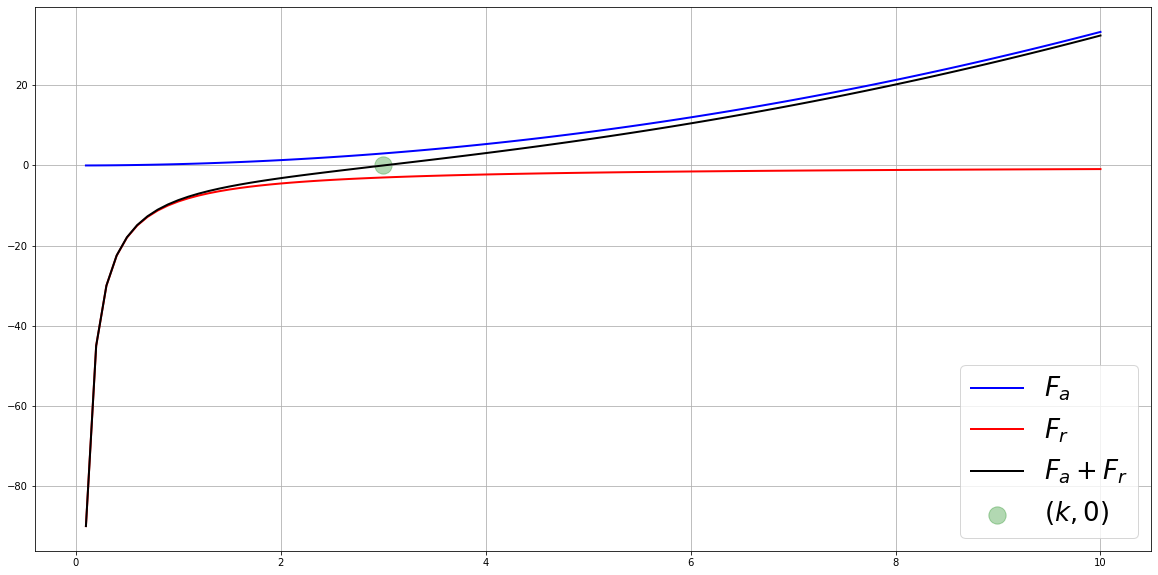

In [9]:
plt.figure(figsize=(20, 10))
plt.axis(option='on')

k = 3
ds = np.linspace(0.1, 10, 100)
F_a = (ds ** 2) / k
F_r = -(k ** 2) / ds

plt.plot(ds, F_a, label=r'$F_a$', lw=2, c='b')
plt.plot(ds, F_r, label=r'$F_r$', lw=2, c='r')
plt.plot(ds, F_a + F_r, label=r'$F_a + F_r$', lw=2, c='k')
plt.scatter([k], [0], label=r'$(k, 0)$', c='g', s=300, alpha=0.3)

plt.legend(fontsize=26)
plt.grid()

На графике видно, что сумма сил между смежными вершинами 0, когда расстояние между ними $k$. 

Другие, менее существенные, отличия от Eades:

1) не допускается выход вершин за пределы экрана, если в результате очередной итерации координата вершины, скажем $x_i$, выходит за пределы отрезка $[x_{min}, x_{max}]$, то её полагают равной ближайшей границе отрезка  
2) вводится температура $t(n) = (a n + \frac{10}{w})^{-1}$, где $a$ -- подбираемый параметр, $n$ -- номер итерации алгоритма, $w$ -- ширина экрана. Модуль перемещения вершины на итерации ограничивается сверху $t(n)$  
3) $F_r$ считается не между всеми парами вершин, что делает время обсчета итерации $O(|V|^2)$ (ровно столько же занимает итерация и для Eades), но экран разбивается на квадратную сетку стороной $2k$ и считается $F^{'}_r = \frac{k^2}{d} I(d < 2k)$, таким образом, в предположении равномерного распределения вершин по экрану, время итерации сокращается до $O(|V|)$, что быстрее Eades.

In [10]:
class FruchtermanGraph(DynamicGraph):
    _COEFF = [0.6, 0.1]
    
    def _generate_states(self, state): 
        width, height = self._box[:, 1] - self._box[:, 0]
        k = self._COEFF[0] * (np.sqrt(width * height / self._graph.number_of_nodes()))
        grid_w = 2 * k
        grid_size = [int(np.ceil(param / grid_w)) for param in [width, height]]
        
        for step in count():
            temperature = 1 / (self._COEFF[1] * step + 10 / width)
            grid = [[[] 
                     for _ in range(grid_size[0])] 
                    for _ in range(grid_size[1])]
            
            for node, p in enumerate(state):
                index = [min(size - 1, int(float_index)) 
                         for size, float_index in zip(grid_size, (p - self._box[:, 0]) / grid_w)]
                grid[index[0]][index[1]].append(node)
            
            forces = np.zeros((self._graph.number_of_nodes(), 2))
            
            for i, row in enumerate(grid):
                for j, cell in enumerate(row):
                    for u in cell:
                        for delta_i in [-1, 0, 1]:
                            for delta_j in [-1, 0, 1]:
                                close_i, close_j = i + delta_i, j + delta_j
                                
                                if 0 <= close_i < len(grid) and 0 <= close_j < len(row):
                                    for w in grid[close_i][close_j]:
                                        if u != w:
                                            distance, direction = distance_direction(state[u], state[w])
                                            if distance < grid_w:
                                                forces[u] += direction * (k ** 2) / distance
            
            for u, w in self._graph.edges:
                distance, direction = distance_direction(state[u], state[w])
                force = direction * (distance ** 2) / k
                
                forces[u] -= force
                forces[w] += force
            
            for i, force in enumerate(forces):
                force_norm = np.linalg.norm(force)
                if force_norm > 0:
                    state[i] += force * min(force_norm, temperature) / force_norm
                
                for j in range(2):
                    state[i, j] = min(self._box[j, 1], max(self._box[j, 0], state[i, j]))
            
            yield state

## "An algorithm for drawing general undirected graphs" (Kamada, Kawai) 1989

Этот алгоритм отличается от предыдущих, тем что в нем сразу явно прописывается функция энергии системы от координат вершин графа, а потом её можно оптимизировать любым понравишимся методом. Идея энергии исходит из того предположения, что евклидово расстояние $|p_i - p_j|$ между вершинами $v_i$ и $v_j$ в визуализации должно быть пропорционально длине кратчайшего пути между этими вершинами в графе $d_{ij}$. $d_{ij}$ могут быть рассчитаны алгоритмом Флойда-Уоршелла. 
<center>
    $E = \sum\limits_{i = 1}^{n - 1} \sum\limits_{j = i + 1}^{n} \frac{1}{2} k_{ij} (|p_i - p_j| - l_{ij})^2$<br>
    $k_{ij} = \frac{1}{d_{ij}^2}$<br>
    $l_{ij} = d_{ij} \frac{w}{\max d_{ij}}$, где $w$ -- ширина экрана
</center>

$l_{ij}$ подбираются так, чтобы евклидово расстояние между самыми далекими вершинами в графе в смысле расстояния по ребрам было равно $w$. $k_{ij}$ необходимо, чтобы пары вершин, путь между которыми в графе велик, вносили тот же вклад в энергию, что и пары, путь между которыми в графе мал. 

Далее в статье предлагается следующий метод оптимизации:

1) $m = \underset{i}{\operatorname{argmax}} |\nabla_{p_i} E|$  
2) Пока $|\nabla_{p_m} E| > \varepsilon$ делаем шаги по методу Ньютона  
3) Возвращаемся к пукту 1

Соответственно, градиент и гессиан $E$ посчитаны в статье аналитически.

In [11]:
KamadaParams = namedtuple('KamadaParams', 'k l')

class BaseKamadaGraph(DynamicGraph):
    def __init__(self, *args, **kwargs):
        super(BaseKamadaGraph, self).__init__(*args, **kwargs)
        
        self._init_params()
    
    def _init_params(self):
        d = nx.floyd_warshall_numpy(self._graph).A
        l = d * (self._box[0, 1] - self._box[0, 0]) / d.max()
        eye = np.eye(self._graph.number_of_nodes())
        k = 1 / (d ** 2 + eye) * (1 - eye)
        
        self._params = KamadaParams(k=k, l=l)

In [12]:
class VanillaKamadaGraph(BaseKamadaGraph):
    _EPS = 0.5
    
    def _dr(self, row):
        return np.repeat(row, 2).reshape(-1, 2)
    
    def _m_diff(self, m, state):
        m_diff = state[m] - state
        m_diff[m] = 1
        
        return m_diff
    
    def _grad_e(self, m, state):
        m_diff = self._m_diff(m, state)
        mult = self._params.k[m] * (1 - self._params.l[m] / np.sqrt(np.sum(m_diff ** 2, axis=1)))
        return np.sum(self._dr(mult) * m_diff, axis=0)
    
    def _hessian_e(self, m, state):
        m_diff = self._m_diff(m, state)
        denom = np.sum(m_diff ** 2, axis=1) ** 1.5
        
        xy = self._params.k[m] * self._params.l[m] * np.product(m_diff, axis=1) / denom
        xx_yy = self._dr(self._params.k[m]) * (1 - self._dr(self._params.l[m]) * (m_diff ** 2) / self._dr(denom))
    
        return np.sum([[xx_yy[:, 1], xy], [xy, xx_yy[:, 0]]], axis=-1)
    
    def _generate_states(self, state): 
        while True:
            _, m = max([(np.linalg.norm(self._grad_e(i, state)), i) for i in range(self._graph.number_of_nodes())])
            
            while True:
                grad = self._grad_e(m, state)
                hessian = self._hessian_e(m, state)
                
                dp = np.matmul(np.linalg.inv(hessian), grad)
                state[m] -= dp
                
                yield state
                
                if np.linalg.norm(grad) < self._EPS:
                    break

Так как сейчас существует много реализаций автоградиента, нет необходимости вручную считать градиент и гессиан. Просто с помощью `tensorflow` выразим функцию энергии и будем оптимизировать её градиентным спуском. Тут, в отличие от процесса оптимизации из статьи на каждой итерации двигаются сразу все вершины и итераций нужно меньше.

In [13]:
class TensorflowKamadaGraph(BaseKamadaGraph):
    def _generate_states(self, state):
        tf.reset_default_graph()
        
        state_var = tf.Variable(state, dtype=tf.float32)
        n = self._graph.number_of_nodes()
        
        ps = tf.tile(state_var, [1, state_var.shape[0]])
        ps = tf.reshape(ps, shape=[state_var.shape[0], state_var.shape[0], 2])
        pst = tf.transpose(ps, perm=[1, 0, 2])
        diffs = tf.sqrt(tf.maximum(0., tf.reduce_sum((ps - pst) ** 2, axis=-1)))
        energy = tf.reduce_sum(self._params.k * ((diffs - self._params.l) ** 2))
        
        train_step = tf.train.AdamOptimizer(10).minimize(energy)
        
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        
        while True:
            sess.run(train_step)
            
            yield sess.run(state_var)

## Сравнение алгоритмов

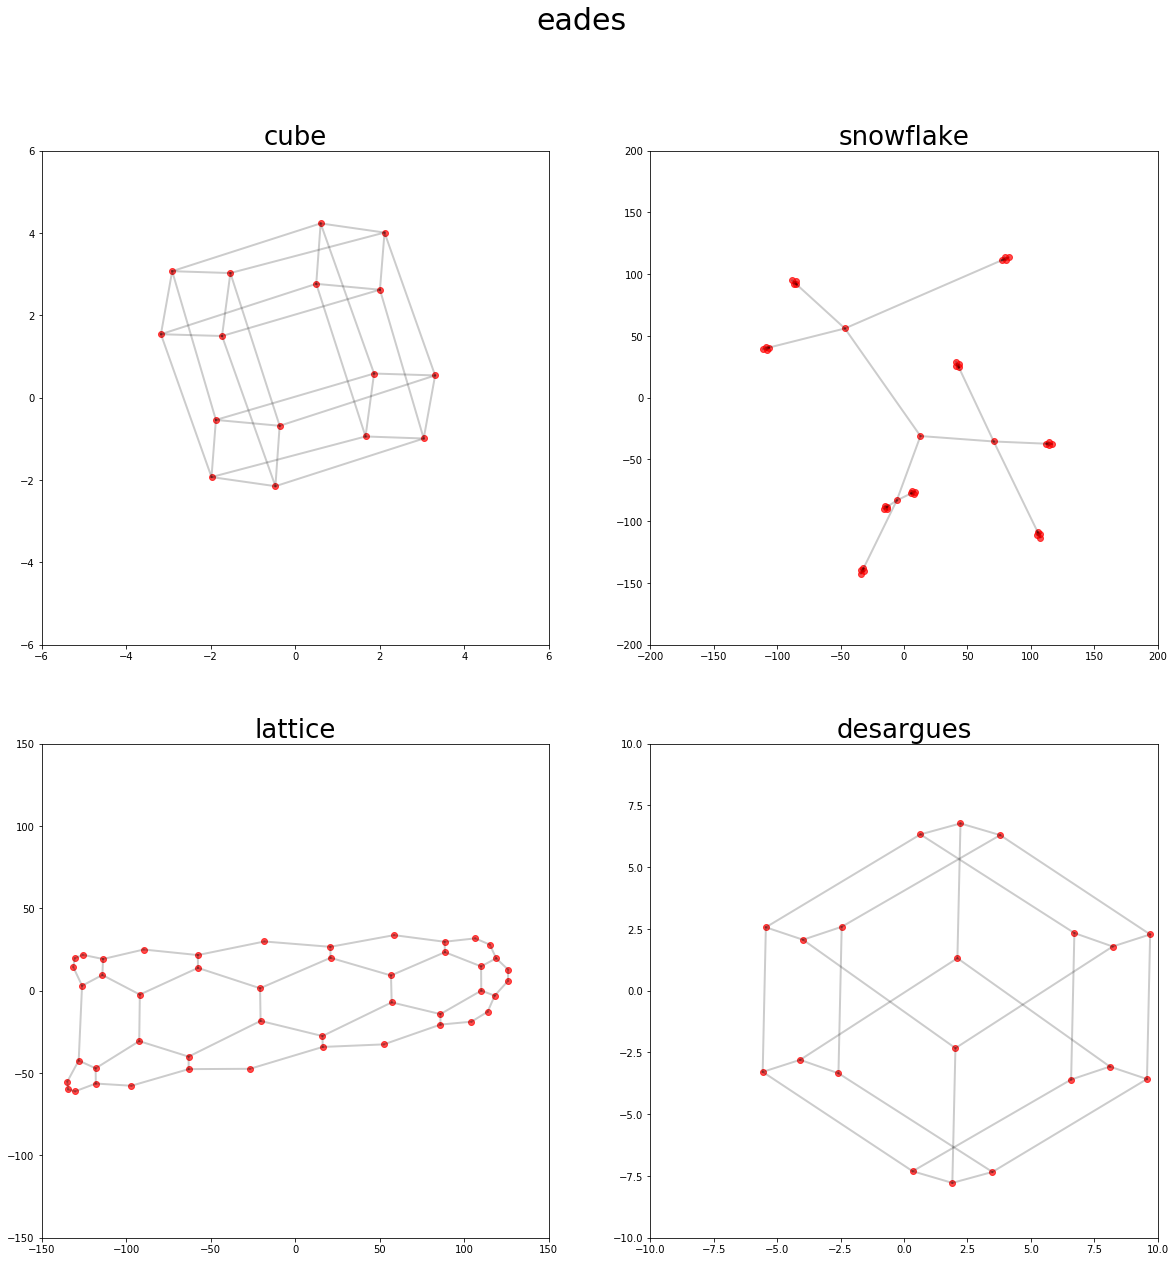

In [14]:
show_algorithm(EadesGraph, 'eades', kwargs={
    'cube': {'box': square_box(6), 'steps': 90},
    'snowflake': {'box': square_box(200), 'steps': 1000},
    'lattice': {'box': square_box(150), 'steps': 1000},
    'desargues': {'box': square_box(10), 'steps': 500},
})

Хорошо связные центрально симметричные конструкции рисуются центрально симметрично. В графах решетки и снежинки наблюдаем проблемы несбалансированности сил: хоть графы эти обладают симметрией, силы распределяют вершины так, что длина ребер в разных сегментах этих графов сильно разнится. Также можно видеть, что величины экранов тут сильно разнятся в зависимости от графов, и их пришлось подбирать вручную.

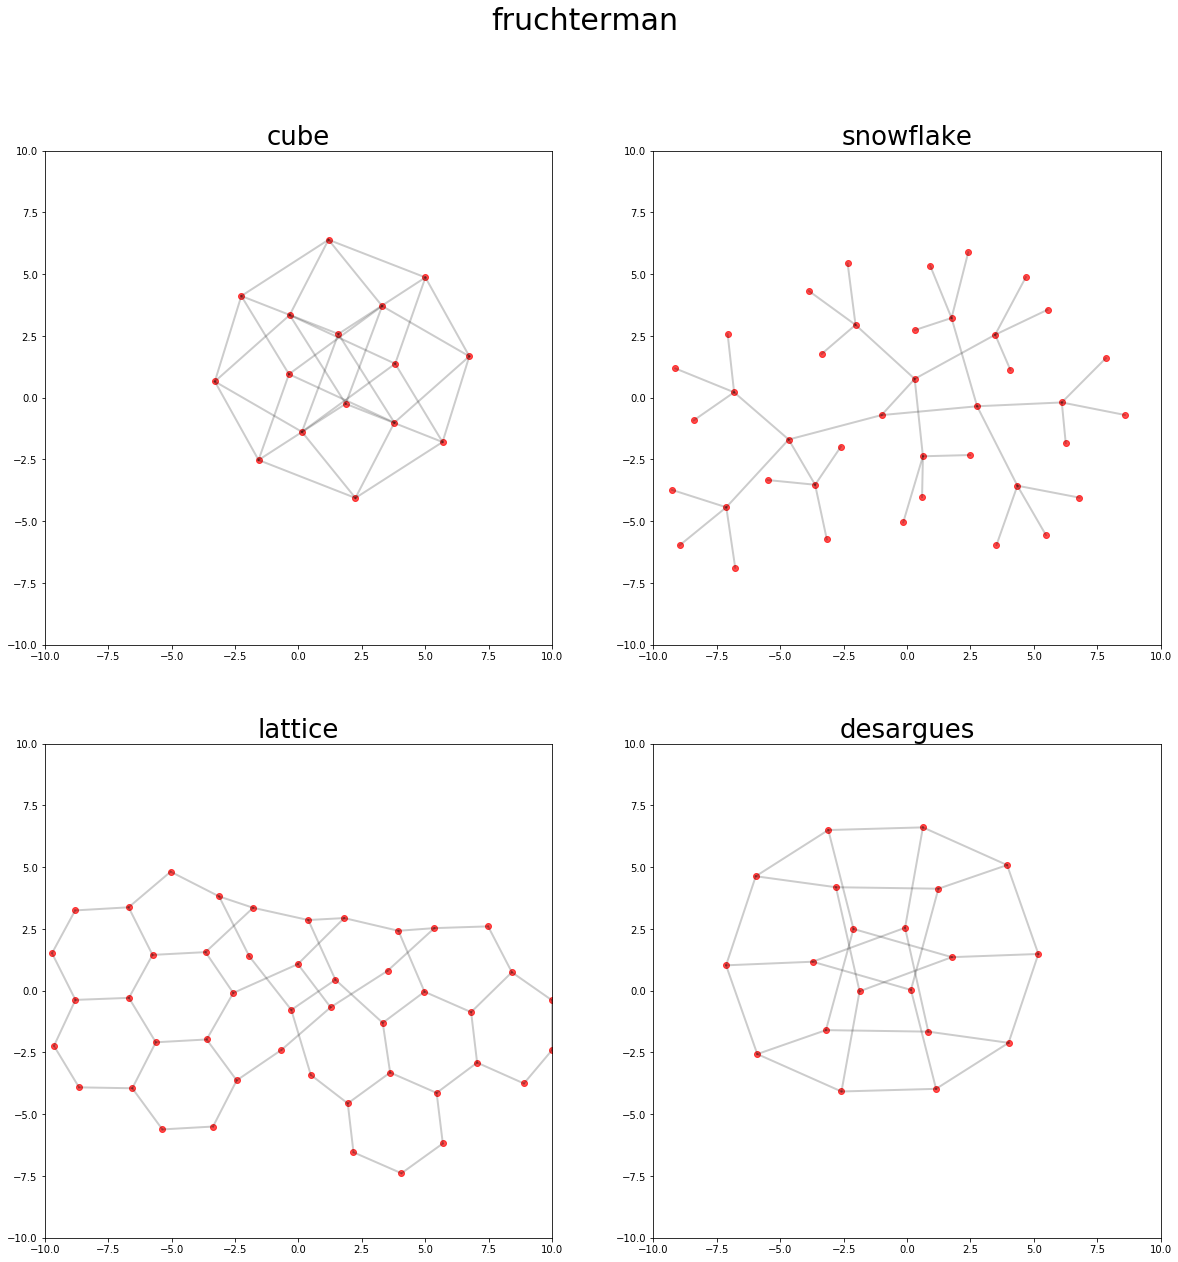

In [18]:
show_algorithm(partial(FruchtermanGraph, steps=2000), 'fruchterman')

Здесь все гораздо лучше касательно равномерного распределения вершин по экрану и сбалансированности длин ребер, однако есть такой эффект, что если конструкция на каком-то шаге итеративного процесса "запуталась", то ей тяжело перевалить за потенциальный барьер и распутаться, иначе говоря, система легко застревает в локальных минимумах энергии. Это видно на графах решетки и снежинки, особенно хорошо этот эффект наблюдается в анимации: вершины хотят распутаться, но не могут.

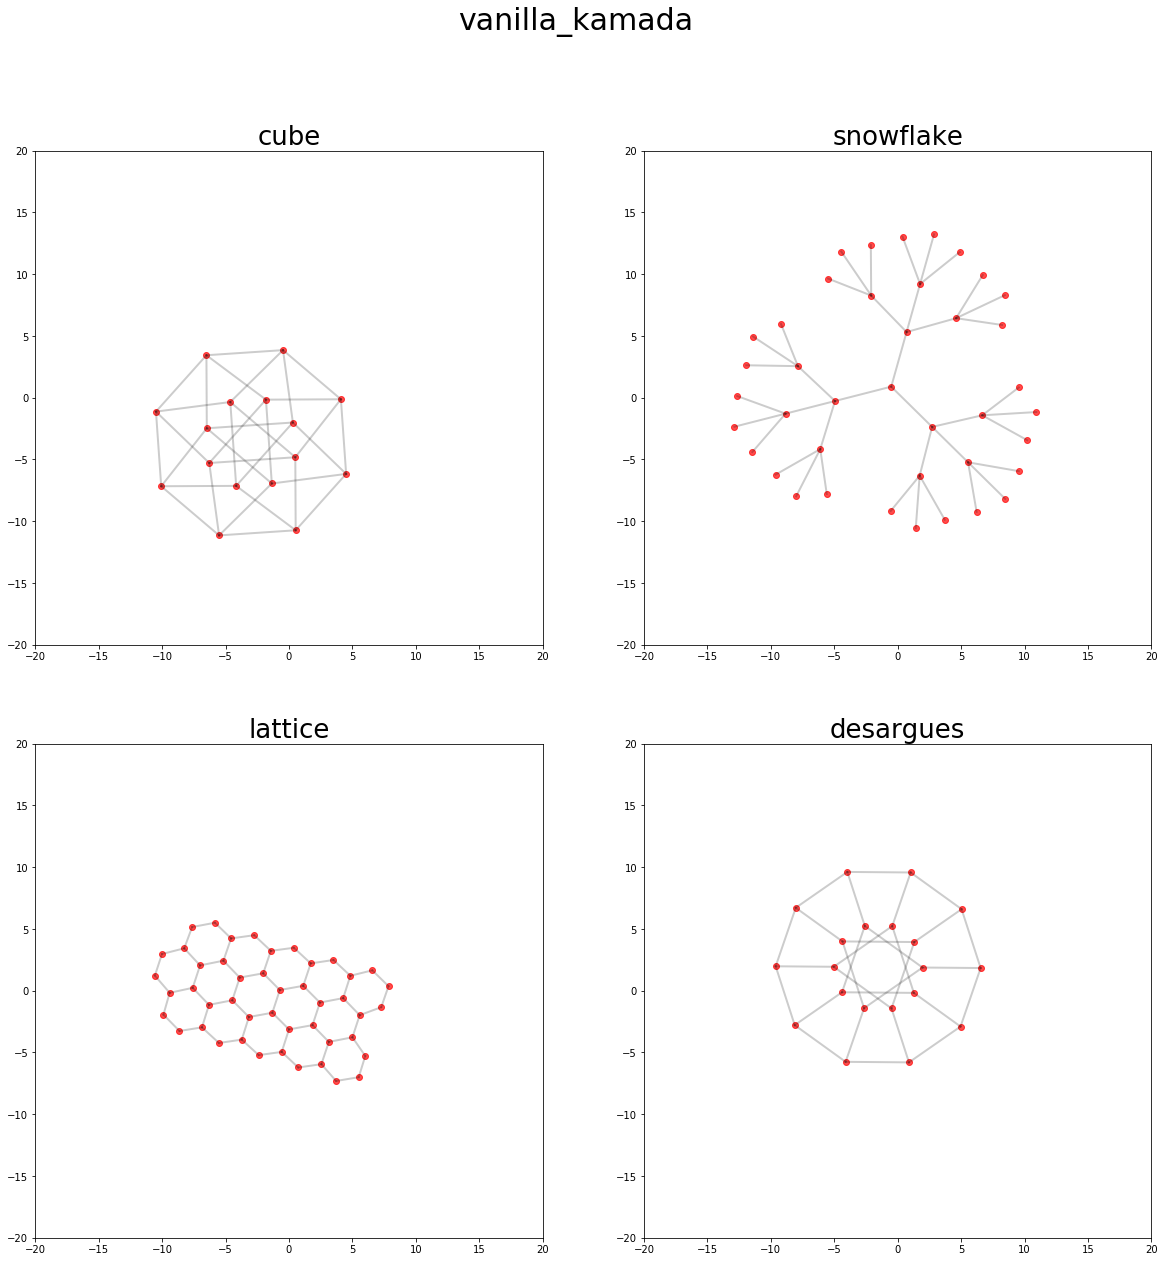

In [19]:
show_algorithm(partial(VanillaKamadaGraph, display_ratio=2, steps=3000), 'vanilla_kamada')

Здесь наблюдаем гораздо более высокий уровень симметрии фигур, проблем с застреванием в локальных минимумах не надблюдается. На анимации решетка, будучи запутанной потихоньку распутывается. Ожидаемо, снежинка тут выглядит самой приятной с четко выдержанными длинами ребер и симметрией.

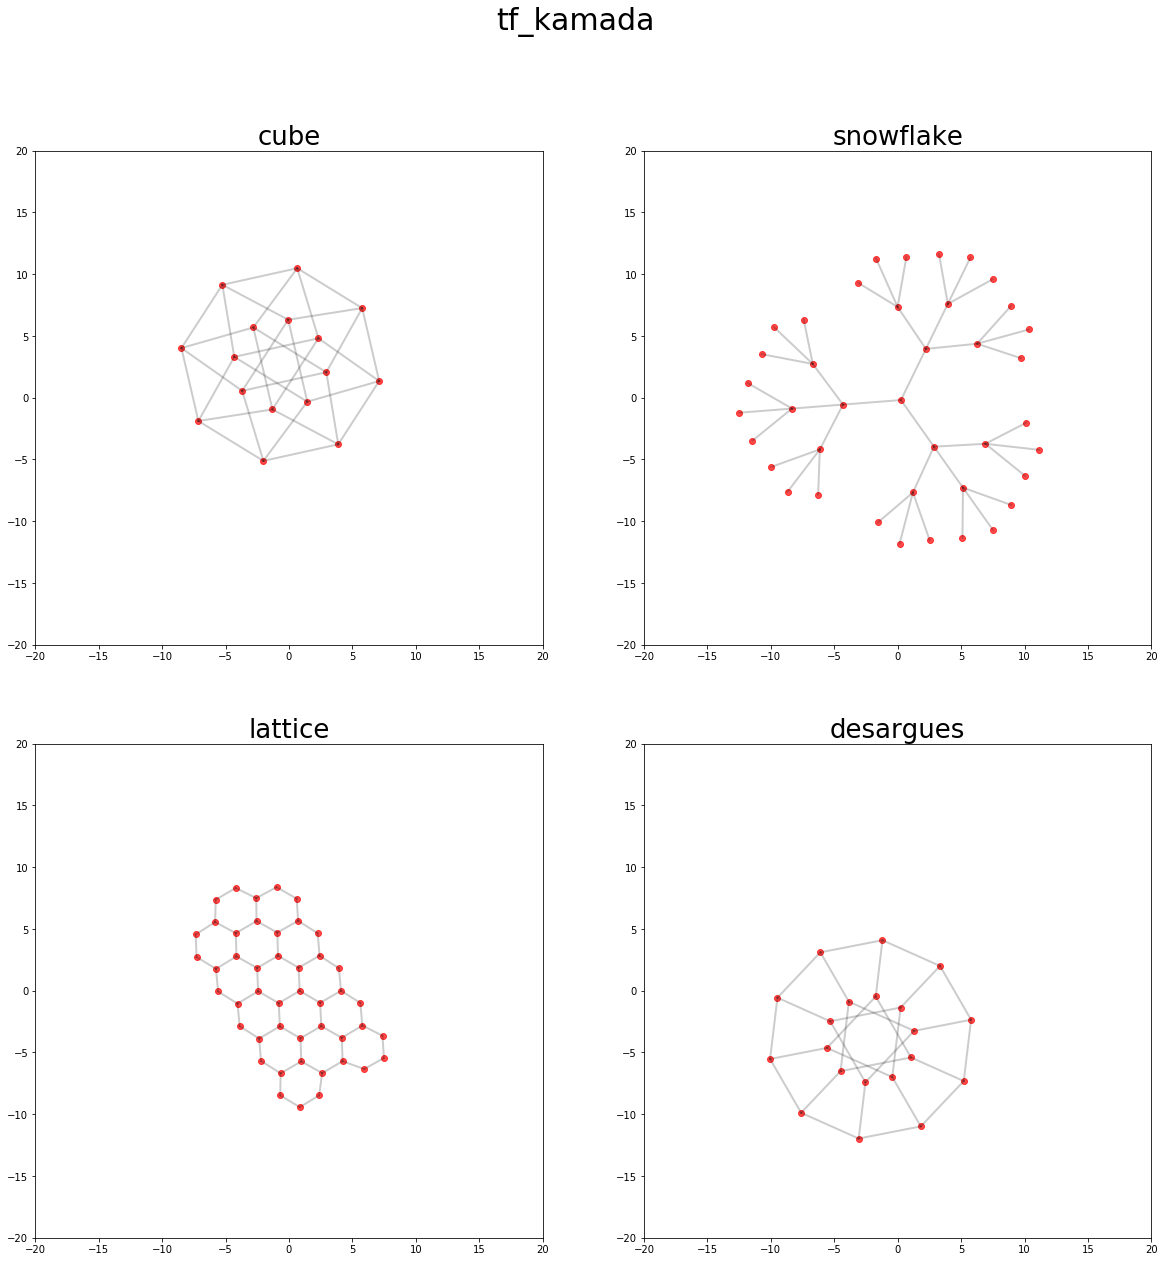

In [22]:
show_algorithm(partial(TensorflowKamadaGraph, display_ratio=2, steps=200), 'tf_kamada')

Как видим, смена метода оптимизации не изменила результата, просто потребовалось меньше итераций, и анимация другая за счет одновременного движения всех вершин.